In [ ]:
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
import sklearn
import numpy as np
import torch
from torchvision import datasets
import torch.nn as nn #this submodule provides tools for building and training neural networks
import torch.optim as optim #this submodule contains information on optimizers such as SGD
import os
from torchvision import models, transforms
from PIL import Image
import requests
import json
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm  

In [2]:
# To make this notebook's output stable across runs
np.random.seed(42)
torch.manual_seed(42)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:
BATCH_SIZE = 128

In [ ]:
### TAKEN FROM LAB NOTEBOOK ###
# Define the normalization transform for ResNet (ImageNet normalization)
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

def preprocess_image_tensor(image_tensor):
    """
    Preprocess a tensor representing an image for ResNet-50.
    Args:
        image_tensor (torch.Tensor): Input tensor of shape (3, H, W).
    Returns:
        torch.Tensor: Preprocessed tensor of shape (1, 3, 224, 224).
    """
    # Ensure the tensor is a 3-channel image
    assert image_tensor.ndim == 3 and image_tensor.shape[0] == 3, \
        "Input tensor must be of shape (3, H, W)."

    # Convert the tensor to a PIL Image for compatibility with transforms.Resize
    pil_image = transforms.ToPILImage()(image_tensor)  # Convert Tensor to PIL Image

    # Apply resizing and convert back to tensor
    transform_resize = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor()          # Convert back to Tensor
    ])
    image_tensor = transform_resize(pil_image)

    # Normalize the image
    image_tensor = normalize(image_tensor)

    # Add batch dimension
    return image_tensor


In [ ]:
# Load CIFAR-10 dataset
dataset = CIFAR10(root="./data", train=True, download=True, transform=ToTensor())

# Train and validation split
train_size = len(dataset) - 5000  # Keep 5000 samples for validation
valid_size = 5000
train_dataset, valid_dataset = random_split(dataset, [train_size, valid_size])

# Load the test set
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=ToTensor())

# define a prerpocessing pipeline to resize and normalize the data according to resnet-50 since default dataloader doesn't allow for this
class PreprocessDataset:
    def __init__(self, dataset, preprocess_fn):
        self.dataset = dataset
        self.preprocess_fn = preprocess_fn
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        img = self.preprocess_fn(img)
        return img, label

train_preprocessed = PreprocessDataset(train_dataset, preprocess_image_tensor)
valid_preprocessed = PreprocessDataset(valid_dataset, preprocess_image_tensor)
test_preprocessed = PreprocessDataset(test_dataset, preprocess_image_tensor)

# Data loaders for batching
train_loader = DataLoader(train_preprocessed, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_preprocessed, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_preprocessed, batch_size=BATCH_SIZE, shuffle=False)

# Check dataset shapes
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 45000
Validation dataset size: 5000
Test dataset size: 10000


In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

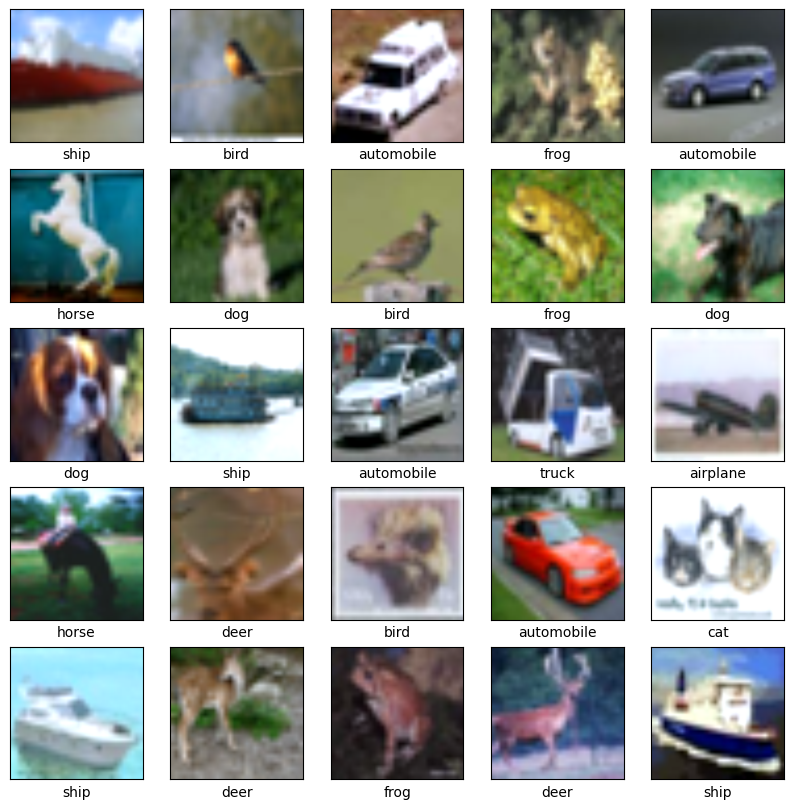

In [38]:
# use the same mean/std you used in transforms
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
std  = torch.tensor([0.2470, 0.2435, 0.2616]).view(3,1,1)

dataiter = iter(train_loader)
images, labels = next(dataiter)  # images: (B, C, H, W)

# If images are on GPU, move to cpu
images = images.cpu()

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([]); plt.yticks([]); plt.grid(False)

    img = images[i].clone()         # avoid modifying the batch
    img = img * std + mean          # unnormalize
    npimg = img.permute(1,2,0).numpy()
    np.clip(npimg, 0, 1, out=npimg) # ensure values in [0,1]
    plt.imshow(npimg)
    plt.xlabel(class_names[labels[i]])
plt.show()

In [50]:
# Load the pretrained ResNet-50 model
weights = models.ResNet50_Weights.DEFAULT  # Use DEFAULT to get the latest pre-trained weights
model = models.resnet50(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 10) # replace final layer to match cifar for 10 classes

# freeze early layers at first
# they learn low level features (edges, curves, corners), provides good headstart as applicable to every image
for name, p in model.named_parameters():
    if name.startswith("layer1") or name.startswith("conv1"):
        p.requires_grad = False

# Loss/optim
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD([
    {"params": [p for n,p in model.named_parameters() if p.requires_grad and 'fc' not in n], "lr": 1e-4}, #low learning rate for convolution layers (n-name(eg. conv1), p-parameter(eg. nn.conv2d()))
    {"params": model.fc.parameters(), "lr": 1e-3} # higher learning rate (most learning happens here)
], momentum=0.9, weight_decay=5e-4)

In [51]:
#RESNET-50 architecture
model.named_parameters()

<generator object Module.named_parameters at 0x7fe8b9df63b0>

In [54]:
def train_and_val(model, optimizer, criterion, epochs=10):
    model.to(device)

    # Loss and optimizer
    criterion = criterion
    optimizer = optimizer
    # Initialize lists to store metrics
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    # Training loop
    epochs = epochs
    epoch_bar = tqdm(range(epochs), desc="Epochs", unit="epoch")

    for epoch in epoch_bar:
        model.train()  # Set model to training mode
        correct = 0
        total = 0
        running_loss = 0.0

        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} Train", leave=False, unit="batch")
        for X_batch, y_batch in train_bar:
            X_batch, y_batch = X_batch.to(device, non_blocking=True), y_batch.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
            
            # update the training progress bar postfix
            cur_loss = running_loss / (len(train_bar) if hasattr(train_bar, "n") and train_bar.n>0 else 1)
            cur_acc = correct / total if total > 0 else 0.0
            train_bar.set_postfix(loss=f"{cur_loss:.4f}", acc=f"{cur_acc:.4f}")


        train_epoch_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)
        train_losses.append(train_epoch_loss)


        # Validation step
        model.eval()  # Set model to evaluation mode
        val_running = 0.0
        val_correct = 0
        val_total = 0
        
        val_bar = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} Val", leave=False, unit="batch")
        with torch.no_grad():
            for X_val, y_val in val_bar:
                X_val, y_val = X_val.to(device, non_blocking=True), y_val.to(device, non_blocking=True)
                val_outputs = model(X_val)
                val_loss = criterion(val_outputs,y_val)
                val_running += val_loss.item()
                
                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == y_val).sum().item()
                val_total += y_val.size(0)
                
                # update the validation progress bar postfix
                cur_val_loss = val_running / (len(val_bar) if hasattr(val_bar, "n") and val_bar.n>0 else 1)
                cur_val_acc = val_correct / val_total if val_total > 0 else 0.0
                val_bar.set_postfix(loss=f"{cur_val_loss:.4f}", acc=f"{cur_val_acc:.4f}")
        
        val_epoch_loss = val_running / len(valid_loader)            
        val_accuracy = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_accuracy)


        # Update outer epoch bar postfix (shown next to Epochs bar)
        epoch_bar.set_postfix(
            train_loss=f"{train_epoch_loss:.4f}",
            train_acc=f"{train_accuracy:.4f}",
            val_loss=f"{val_epoch_loss:.4f}",
            val_acc=f"{val_accuracy:.4f}"
        )

    loss_df = pd.DataFrame({
        'epoch': list(range(1, epochs + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'train_acc': train_accuracies,
        'val_acc': val_accuracies
    })
    torch.save(model.state_dict(), f"cifar_finetuned.pth")
        
    return loss_df
        
        

In [55]:
train_df = train_and_val(model, optimizer, criterion)

Epochs: 100%|██████████| 10/10 [25:46<00:00, 154.63s/epoch, train_acc=0.9262, train_loss=0.2250, val_acc=0.9058, val_loss=0.2686]


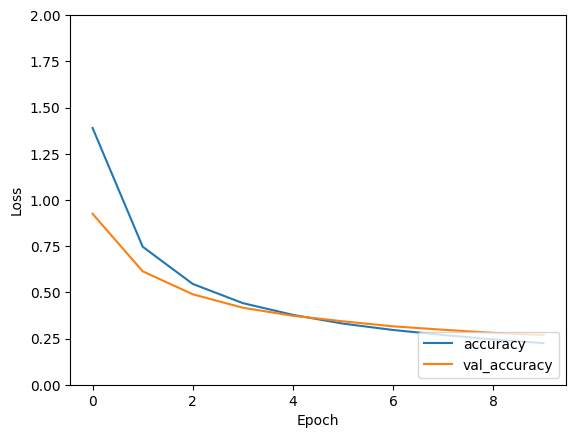

In [62]:
# Plot the loss
plt.plot(train_df['train_loss'], label='accuracy')
plt.plot(train_df['val_loss'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='lower right')
plt.show()

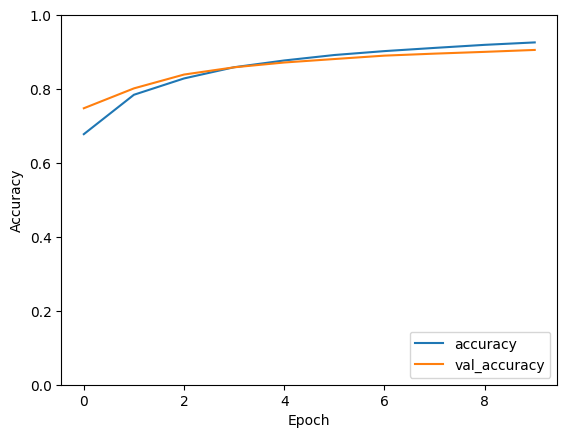

In [63]:
# Plot the accuracies
plt.plot(train_df['train_acc'], label='accuracy')
plt.plot(train_df['val_acc'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Evaluate on test data
model.eval()  # Set model to evaluation mode
test_correct = 0
test_total = 0

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        # Move test data to the selected device
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)

        test_outputs = model(X_test_batch)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == y_test_batch).sum().item()
        test_total += y_test_batch.size(0)

test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9067


: 